# E-Commerce Data Analysis Using Python (EDA)

### 1.  INITIAL SETUP AND DATA LOADING

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Data Loading
df = pd.read_csv('C:/Users/MAINAK AS/OneDrive/Desktop/E-Commerce Data/ecomm_data.csv', encoding = 'unicode_escape')


print("Dataset Shape:", df.shape)
print("First 5 Rows:")
print(df.head())


Dataset Shape: (541909, 8)
First 5 Rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


### 2. ETL PROCESS - DATA TYPE CONVERSION

In [2]:
# Converting columns to appropriate data types with error handling

def convert_data_types(df):

    df_clean = df.copy()

    df_clean['InvoiceNo'] = df_clean['InvoiceNo'].astype('category', errors='ignore')  # InvoiceNo to category
    df_clean['StockCode'] = df_clean['StockCode'].astype('category', errors='ignore')  # StockCode to category
    df_clean['Description'] = df_clean['Description'].astype('category', errors='ignore')  # Description to category
    df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')  # Ensuring numeric columns
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')   # InvoiceDate to datetime
    df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')  # Ensuring numeric columns
    df_clean['CustomerID'] = df_clean['CustomerID'].astype('str', errors='ignore')  # CustomerID to str
    df_clean['Country'] = df_clean['Country'].astype('category', errors='ignore')      # Country to category

    return df_clean

df_clean = convert_data_types(df)


print("Original Data Types:")
print(df.dtypes)
print("Data Types after Conversion:")
print(df_clean.dtypes)
print("Missing Values in Original Data:")
print(df.isnull().sum())
print("Missing Values after Conversion:")
print(df_clean.isnull().sum())
print(f"Original data shape: {df.shape}")
print(f"After type conversion: {df_clean.shape}")


Original Data Types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
Data Types after Conversion:
InvoiceNo            category
StockCode            category
Description          category
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country              category
dtype: object
Missing Values in Original Data:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Missing Values after Conversion:
InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64
Original data shape: (541909, 8)
After type conversion: (541909, 8)


### 3. NULL VALUE ANALYSIS AND TREATMENT

In [3]:
def analyze_and_treat_nulls(df):

    print("=== NULL VALUE ANALYSIS ===")
    null_summary = df.isnull().sum()
    null_percentage = (df.isnull().sum() / len(df)) * 100
    null_df = pd.DataFrame({'Null Count': null_summary, 'Null Percentage': null_percentage})
    print(null_df[null_df['Null Count'] > 0])

    df_treated = df.copy()


    # Logical null treatments with explanations:

    # 1. CustomerID nulls - Create 'Unknown Customer' category
    # Reason: We don't know who bought these, but we want to keep the sales data.
    customer_nulls_before = df_treated['CustomerID'].isnull().sum()
    df_treated['CustomerID'] = df_treated['CustomerID'].fillna('Unknown')
    print(f"\nCustomerID: Filled {customer_nulls_before} nulls with 'Unknown'")

    # 2. Description nulls - Use mode (most frequent category)
    # Reason: Description is categorical, mode is reasonable for categorical data.
    description_nulls_before = df_treated['Description'].isnull().sum()
    if description_nulls_before > 0:
        mode_description = df_treated['Description'].mode()[0]
        df_treated['Description'] = df_treated['Description'].fillna(mode_description)
        print(f"Description: Filled {description_nulls_before} nulls with mode: {mode_description}")

    # 3. Quantity nulls - Use median (robust to outliers)
    # Reason: Quantity may have outliers, median is better than mean.
    quantity_nulls_before = df_treated['Quantity'].isnull().sum()
    if quantity_nulls_before > 0:
        median_quantity = df_treated['Quantity'].median()
        df_treated['Quantity'] = df_treated['Quantity'].fillna(median_quantity)
        print(f"Quantity: Filled {quantity_nulls_before} nulls with median: {median_quantity}")

    # 4. UnitPrice nulls - Use median
    # Reason: Price data often has outliers.
    price_nulls_before = df_treated['UnitPrice'].isnull().sum()
    if price_nulls_before > 0:
        median_price = df_treated['UnitPrice'].median()
        df_treated['UnitPrice'] = df_treated['UnitPrice'].fillna(median_price)
        print(f"UnitPrice: Filled {price_nulls_before} nulls with median: {median_price}")

    # 5. Country nulls - Use mode
    country_nulls_before = df_treated['Country'].isnull().sum()
    if country_nulls_before > 0:
        mode_country = df_treated['Country'].mode()[0]
        df_treated['Country'] = df_treated['Country'].fillna(mode_country)
        print(f"Country: Filled {country_nulls_before} nulls with mode: {mode_country}")

    print(f"\nRemaining nulls after treatment: {df_treated.isnull().sum().sum()}")
          
    return df_treated
          
df_treated = analyze_and_treat_nulls(df_clean)


=== NULL VALUE ANALYSIS ===
             Null Count  Null Percentage
Description        1454         0.268311

CustomerID: Filled 0 nulls with 'Unknown'
Description: Filled 1454 nulls with mode: WHITE HANGING HEART T-LIGHT HOLDER

Remaining nulls after treatment: 0


### 4. INVALID VALUE TREATMENT

In [4]:
# Handle invalid values in the dataset

def treat_invalid_values(df):

    df_valid = df.copy()
    original_rows = len(df_valid)

    print("=== INVALID VALUE TREATMENT ===")

    # Check for negative quantities (returns/cancellations)
    negative_quantity = (df_valid['Quantity'] < 0).sum()
    print(f"Negative Quantity entries: {negative_quantity}")

    # Check for neative prices
    negative_price = (df_valid['UnitPrice'] < 0).sum()
    print(f"Negative UnitPrice entries: {negative_price}")

    # Check for zero prices 
    zero_price = (df_valid['UnitPrice'] == 0).sum()
    print(f"Zero UnitPrice entries: {zero_price}")


    # Treatment decisions:
    # 1. Keep negative quantities (they represent returns/cancellations)
    # 2. Remove negative prices (invalid data)
    # 3. Keep zero prices (could be free items/promotions)


    # Remove entries with negative prices (invalid busines data)
    df_valid = df_valid[df_valid['UnitPrice'] >= 0]
    print(f"Removed {negative_price} rows with negative UnitPrice.")

    print(f"Rows before treatment: {original_rows}")
    print(f"Rows after treatment: {len(df_valid)}")
    print(f"Data loss: {((original_rows - len(df_valid)) / original_rows) * 100:.2f}%")

    return df_valid

df_valid = treat_invalid_values(df_treated)

=== INVALID VALUE TREATMENT ===
Negative Quantity entries: 10624
Negative UnitPrice entries: 2
Zero UnitPrice entries: 2515
Removed 2 rows with negative UnitPrice.
Rows before treatment: 541909
Rows after treatment: 541907
Data loss: 0.00%


### 5. FEATURE ENGINEERING - SALES AMOUNT

In [5]:
# Create new features for analysis

def create_sales_features(df):

    df_featured = df.copy()

    # Create SalesAmount
    df_featured['SalesAmount'] = df_featured['Quantity'] * df_featured['UnitPrice']

    # Extract date components for time series analysis
    df_featured['Year'] = df_featured['InvoiceDate'].dt.year
    df_featured['Month'] = df_featured['InvoiceDate'].dt.month
    df_featured['Day'] = df_featured['InvoiceDate'].dt.day
    df_featured['Weekday'] = df_featured['InvoiceDate'].dt.day_name()
    df_featured['Hour'] = df_featured['InvoiceDate'].dt.hour

    # Create Month-Year for time series
    df_featured['MonthYear'] = df_featured['InvoiceDate'].dt.to_period('M')

    print("Create new features: SalesAmount, Year, Month, Day, Weekday, Hour, MonthYear")
    print(f"Sample SalesAmount stats:")
    print(f"Min: {df_featured['SalesAmount'].min():2f}")
    print(f"Max: {df_featured['SalesAmount'].max():2f}")
    print(f"Mean: {df_featured['SalesAmount'].mean():2f}")
    print(f"Median: {df_featured['SalesAmount'].median():2f}")


    return df_featured

df_final = create_sales_features(df_valid) 

Create new features: SalesAmount, Year, Month, Day, Weekday, Hour, MonthYear
Sample SalesAmount stats:
Min: -168469.600000
Max: 168469.600000
Mean: 18.028688
Median: 9.750000


### 6. DIMENSIONS EXPLORATION

In [6]:
print("===DIMENSIONS EXPLORATION===")

# Categorical dimensions analysis
categorical_cols = ['Description', 'Country', 'CustomerID']

for col in categorical_cols:
    if col in df_final.columns:
        print(f"---{col}---")
        print(f"Unique values: {df_final[col].nunique()}")
        print("Top 10 values:")
        print(df_final[col].value_counts().head(10))

===DIMENSIONS EXPLORATION===
---Description---
Unique values: 4223
Top 10 values:
Description
WHITE HANGING HEART T-LIGHT HOLDER    3823
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: count, dtype: int64
---Country---
Unique values: 38
Top 10 values:
Country
United Kingdom    495476
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64
---CustomerID---
Unique values: 4373
Top 10 values:
CustomerID
nan        135078
17841.0      7983
14911.0      5903
14

### 7. DATE RANGE EXPLORATION

In [7]:
print("---DATE RANGE EXPLORATION---")

date_col = 'InvoiceDate'
if date_col in df_final.columns:
    print(f"Date range: {df_final[date_col].min()} to {df_final[date_col].max()}")
    print(f"Total days: {(df_final[date_col].max() - df_final[date_col].min()).days}")
    print(f"Data spans {df_final['Year'].nunique()} year(s)")

    # monthly transaction count
    monthly_transactions = df_final.groupby('MonthYear').size()
    print(f"Monthly transaction volume:")
    print(monthly_transactions)

---DATE RANGE EXPLORATION---
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Total days: 373
Data spans 2 year(s)
Monthly transaction volume:
MonthYear
2010-12    42481
2011-01    35147
2011-02    27707
2011-03    36748
2011-04    29916
2011-05    37030
2011-06    36874
2011-07    39518
2011-08    35282
2011-09    50226
2011-10    60742
2011-11    84711
2011-12    25525
Freq: M, dtype: int64


### 8. MEASURES EXPLORATION - KEY METRICS

In [8]:
print("=== KEY METRICS ===")

key_metrics = {
    'Total Sales': df_final['SalesAmount'].sum(),
    'Total Quantity:': df_final['Quantity'].sum(),
    'Total Transactions': len(df_final),
    'Total Customers': df_final['CustomerID'].nunique(),
    'Total Products': df_final['StockCode'].nunique(),
    'Total Countries': df_final['Country'].nunique(),
    'Average Transaction Value': df_final['SalesAmount'].mean(),
    'Median Transaction Value': df_final['SalesAmount'].median()
}

for metric, value in key_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:,.2f}")
    else:
        print(f"{metric}: {value:,}")

=== KEY METRICS ===
Total Sales: 9,769,872.05
Total Quantity:: 5,176,448
Total Transactions: 541,907
Total Customers: 4,373
Total Products: 4,070
Total Countries: 38
Average Transaction Value: 18.03
Median Transaction Value: 9.75


### 9. MAGNITUDE ANALYSIS

In [9]:
# Analyze magnitude of different dimensions

def magnitude_analysis(df):
    
    print("=== MAGNITUDE ANALYSIS ===")

    # Sales by Country
    country_sales = df.groupby('Country')['SalesAmount'].agg(['sum', 'count']).sort_values('sum', ascending=False)
    print("Top 10 Countries by Sales:")
    print(country_sales.head(10))

    # Sales by Product Description
    product_sales = df.groupby('Description')['SalesAmount'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
    print("Top 10 Products by Sales:")
    print(product_sales.head(10))

    return country_sales, product_sales

country_sales, product_sales = magnitude_analysis(df_final)

=== MAGNITUDE ANALYSIS ===
Top 10 Countries by Sales:
                        sum   count
Country                            
United Kingdom  8209930.484  495476
Netherlands      284661.540    2371
EIRE             263276.820    8196
Germany          221698.210    9495
France           197403.900    8557
Australia        137077.270    1259
Switzerland       56385.350    2002
Spain             54774.580    2533
Belgium           40910.960    2069
Sweden            36595.910     462
Top 10 Products by Sales:
                                          sum  count        mean
Description                                                     
DOTCOM POSTAGE                      206245.48    709  290.896305
REGENCY CAKESTAND 3 TIER            164762.19   2200   74.891905
WHITE HANGING HEART T-LIGHT HOLDER   99668.47   3823   26.070748
PARTY BUNTING                        98302.98   1727   56.921239
JUMBO BAG RED RETROSPOT              92356.03   2159   42.777226
RABBIT NIGHT LIGHT               

### 10. RANKING ANALYSIS

In [10]:
# Perform ranking analysis across different dimensions

def ranking_analysis(df):

    print("=== RANKING ANALYSIS ===")

    # Top products by sales
    top_products = df.groupby(['StockCode', 'Description']).agg({
        'SalesAmount': 'sum', 
        'Quantity': 'sum', 
        'CustomerID': 'nunique'}).sort_values('SalesAmount', ascending=False).head(10)
    
    print("Top 10 Products by Sales:")
    print(top_products)


    # Top customers by sales
    top_customers = df.groupby('CustomerID').agg({
        'SalesAmount': 'sum', 
        'InvoiceNo': 'nunique',
        'Quantity': 'sum'}).sort_values('SalesAmount', ascending=False).head(10)
    
    print("Top 10 Customers by Spending:")
    print(top_customers)

    return top_products, top_customers

top_products, top_customers = ranking_analysis(df_final)

=== RANKING ANALYSIS ===
Top 10 Products by Sales:
                                              SalesAmount  Quantity  \
StockCode Description                                                 
DOT       DOTCOM POSTAGE                        206245.48       707   
22423     REGENCY CAKESTAND 3 TIER              164762.19     13033   
47566     PARTY BUNTING                          98302.98     18022   
85123A    WHITE HANGING HEART T-LIGHT HOLDER     97715.99     35025   
85099B    JUMBO BAG RED RETROSPOT                92356.03     47363   
23084     RABBIT NIGHT LIGHT                     66756.59     30680   
POST      POSTAGE                                66230.64      3003   
22086     PAPER CHAIN KIT 50'S CHRISTMAS         63791.94     18902   
84879     ASSORTED COLOUR BIRD ORNAMENT          58959.73     36381   
79321     CHILLI LIGHTS                          53768.06     10229   

                                              CustomerID  
StockCode Description                

### 11. CHANGE OVER TIME ANALYSIS

=== TIME SERIES ANALYSIS ===
Monthly Trends:
           Total_Sales  Average_Sales  Transaction_Count  Unique_Customers
MonthYear                                                                 
2010-12      748957.02          17.63              42481               949
2011-01      560000.26          15.93              35147               784
2011-02      498062.65          17.98              27707               799
2011-03      683267.08          18.59              36748              1021
2011-04      493207.12          16.49              29916               900
2011-05      723333.51          19.53              37030              1080
2011-06      691123.12          18.74              36874              1052
2011-07      681300.11          17.24              39518               994
2011-08      704804.63          19.98              35282               981
2011-09     1019687.62          20.30              50226              1303
2011-10     1070704.67          17.63              6074

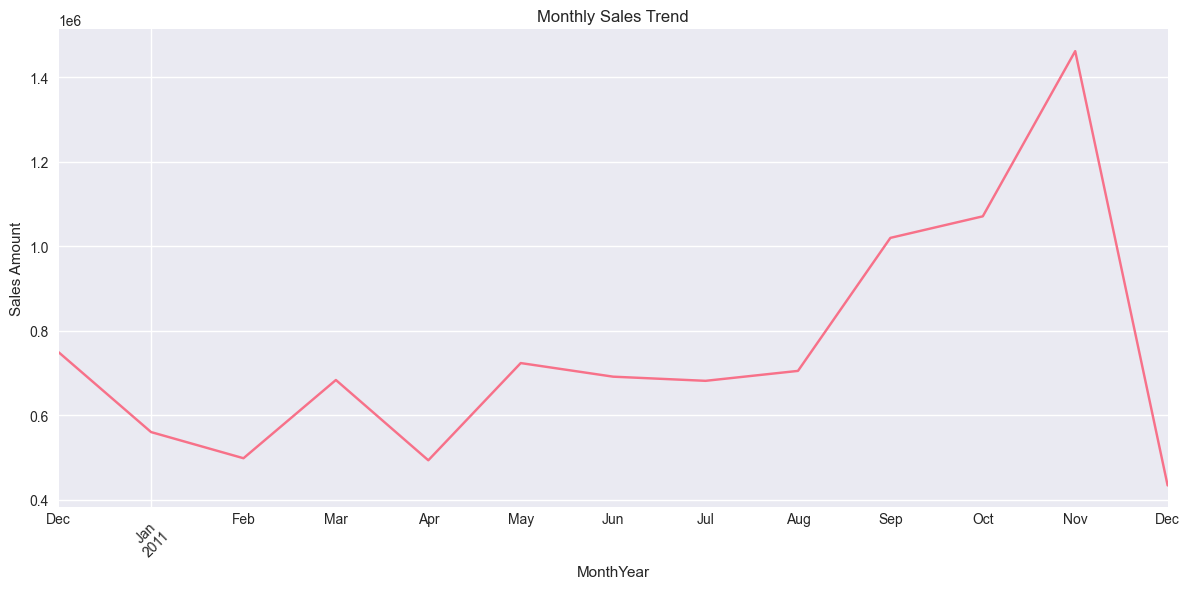

In [11]:
#  Analyze changes over time

def time_series_analysis(df):
    
    print("=== TIME SERIES ANALYSIS ===")

    # Monthly sales trend
    monthly_trend = df.groupby('MonthYear').agg({
        'SalesAmount': ['sum', 'mean', 'count'],
        'CustomerID': 'nunique'
        }).round(2)

    monthly_trend.columns = ['Total_Sales', 'Average_Sales', 'Transaction_Count', 'Unique_Customers']
    print("Monthly Trends:")
    print(monthly_trend)

    # Plot monthly sales trend
    plt.figure(figsize=(12,6))
    monthly_trend['Total_Sales'].plot(kind='line', title='Monthly Sales Trend')
    plt.xticks(rotation=45)
    plt.ylabel('Sales Amount')
    plt.tight_layout()
    plt.show()

    return monthly_trend

monthly_trend = time_series_analysis(df_final)

### 12. CUMULATIVE ANALYSIS

=== CUMULATIVE ANALYSIS ===


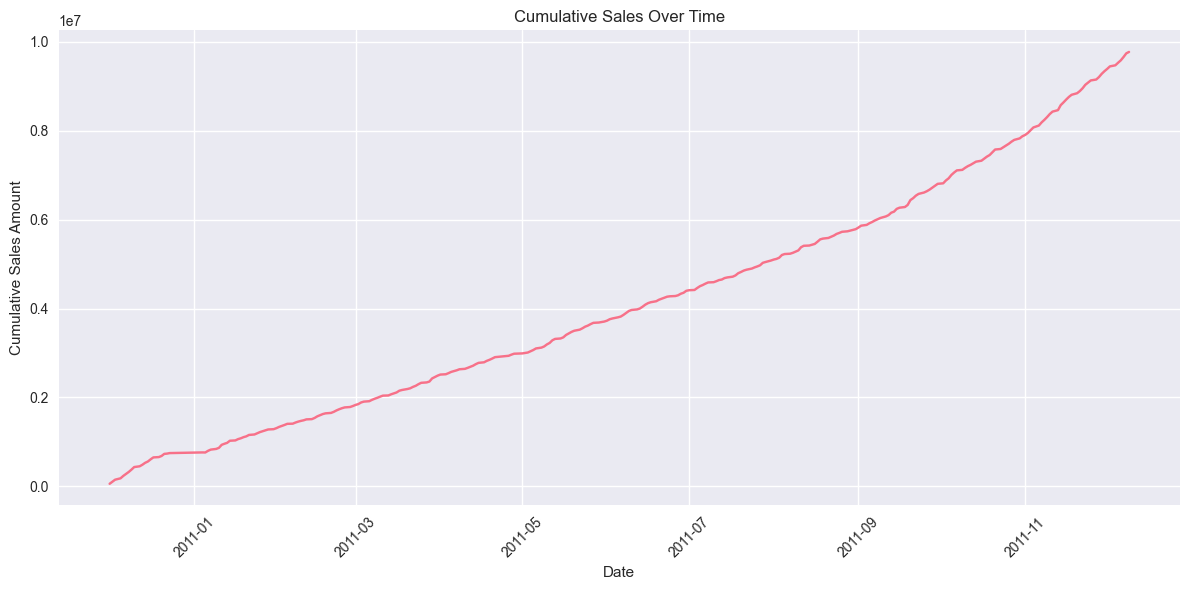

Final cumulative sales: 9,769,872.05


In [12]:
# Perform cumulative analysis

def cumulative_analysis(df):

    print("=== CUMULATIVE ANALYSIS ===")

    # Daily cumulative sales
    daily_sales = df.groupby(df['InvoiceDate'].dt.date)['SalesAmount'].sum().sort_index()
    cumulative_sales = daily_sales.cumsum()

    plt.figure(figsize=(12,6))
    plt.plot(cumulative_sales.index, cumulative_sales.values)
    plt.title('Cumulative Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sales Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Final cumulative sales: {cumulative_sales.iloc[-1]:,.2f}")

    return cumulative_sales

cumulative_sales = cumulative_analysis(df_final)

### 13. PERFORMANCE ANALYSIS - MONTH OVER MONTH

=== MONTH-OVER-MONTH ANALYSIS ===
Month-over-Month Growth:
   MonthYear  Total_Sales  Sales_MoM_Growth  Unique_Customers  \
0    2010-12    748957.02               NaN               949   
1    2011-01    560000.26            -25.23               784   
2    2011-02    498062.65            -11.06               799   
3    2011-03    683267.08             37.18              1021   
4    2011-04    493207.12            -27.82               900   
5    2011-05    723333.51             46.66              1080   
6    2011-06    691123.12             -4.45              1052   
7    2011-07    681300.11             -1.42               994   
8    2011-08    704804.63              3.45               981   
9    2011-09   1019687.62             44.68              1303   
10   2011-10   1070704.67              5.00              1426   
11   2011-11   1461756.25             36.52              1712   
12   2011-12    433668.01            -70.33               687   

    Customer_MoM_Growth  
0   

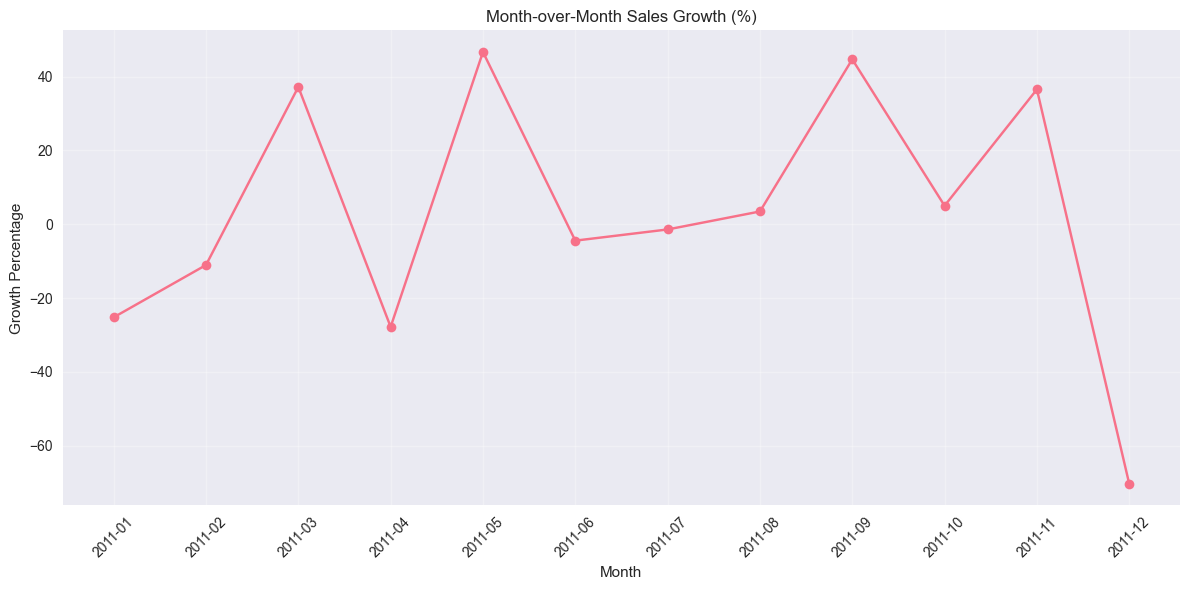

In [13]:
# Month-over-Month performance analysis

def mom_analysis(df):

    print("=== MONTH-OVER-MONTH ANALYSIS ===")

    # Prepare monthly data
    monthly_data = df.groupby('MonthYear').agg({
        'SalesAmount': 'sum',
        'CustomerID': 'nunique',
        'InvoiceNo': 'nunique'
    }).reset_index()

    monthly_data.columns = ['MonthYear', 'Total_Sales', 'Unique_Customers', 'Transaction_Count']

    # Calculate MoM growth
    monthly_data['Sales_MoM_Growth'] = monthly_data['Total_Sales'].pct_change()*100
    monthly_data['Customer_MoM_Growth'] = monthly_data['Unique_Customers'].pct_change()*100
    
    print("Month-over-Month Growth:")
    print(monthly_data[['MonthYear', 'Total_Sales', 'Sales_MoM_Growth', 'Unique_Customers', 'Customer_MoM_Growth']].round(2))

    # Plot MoM Growth
    plt.figure(figsize=(12,6))
    plt.plot(monthly_data['MonthYear'].astype(str), monthly_data['Sales_MoM_Growth'], marker='o')
    plt.title('Month-over-Month Sales Growth (%)')
    plt.xlabel('Month')
    plt.ylabel('Growth Percentage')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return monthly_data

mom_data = mom_analysis(df_final)

### 14. PART-TO-WHOLE ANALYSIS

=== PART-TO-WHOLE ANALYSIS ===
Sales Distribution by Country (%):
Country
United Kingdom    84.033142
Netherlands        2.913667
EIRE               2.694783
Germany            2.269203
France             2.020537
Australia          1.403061
Switzerland        0.577135
Spain              0.560648
Belgium            0.418746
Sweden             0.374579
Name: SalesAmount, dtype: float64


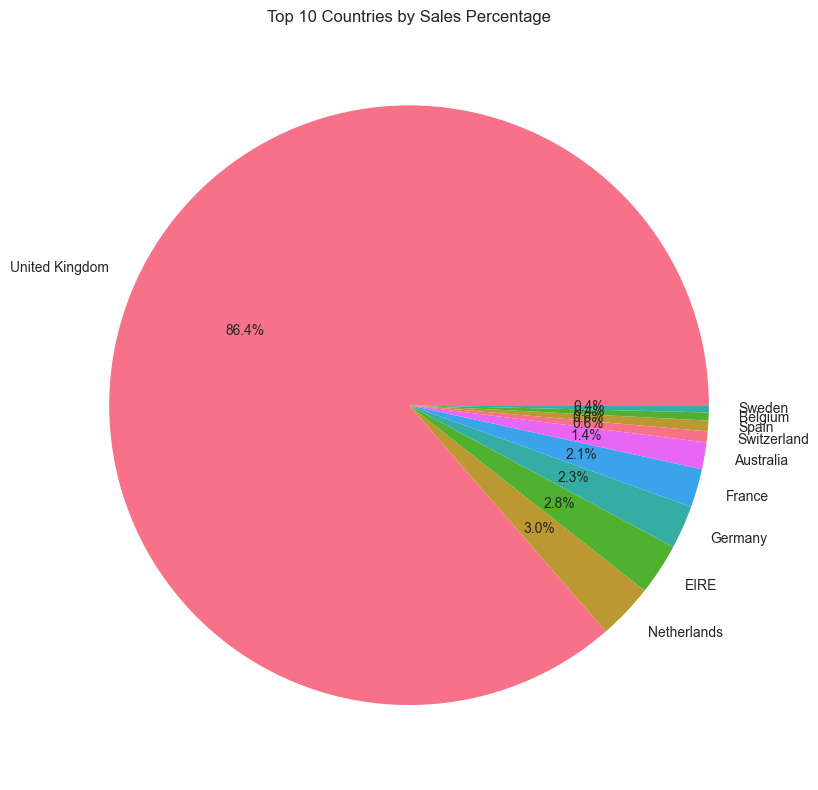

Sales Distribution by Product Type (%):
Description
DOTCOM POSTAGE                        2.111036
REGENCY CAKESTAND 3 TIER              1.686431
WHITE HANGING HEART T-LIGHT HOLDER    1.020161
PARTY BUNTING                         1.006185
JUMBO BAG RED RETROSPOT               0.945315
RABBIT NIGHT LIGHT                    0.683290
POSTAGE                               0.677907
PAPER CHAIN KIT 50'S CHRISTMAS        0.652946
ASSORTED COLOUR BIRD ORNAMENT         0.603485
CHILLI LIGHTS                         0.550346
Name: SalesAmount, dtype: float64


In [14]:
# Analyze parts as percentage of whole

def part_to_whole_analysis(df):

    print("=== PART-TO-WHOLE ANALYSIS ===")

    # Sales distribution by country
    country_distribution = df.groupby('Country')['SalesAmount'].sum()
    country_percentage = (country_distribution / country_distribution.sum() * 100).sort_values(ascending=False)

    print("Sales Distribution by Country (%):")
    print(country_percentage.head(10))

    # Plot top 10 countries by sales percentage
    plt.figure(figsize=(10,8))
    country_percentage.head(10).plot(kind='pie', autopct='%1.1f%%')
    plt.title('Top 10 Countries by Sales Percentage')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # Product type distribution
    product_distribution = df.groupby('Description')['SalesAmount'].sum()
    product_percentage = (product_distribution / product_distribution.sum() * 100).sort_values(ascending=False)

    print("Sales Distribution by Product Type (%):")
    print(product_percentage.head(10))

    return country_percentage, product_percentage

country_pct, product_pct = part_to_whole_analysis(df_final)

### 15. DATA SEGMENTATION ANALYSIS

In [15]:
# Segment data for deeper insights

def segmentation_analysis(df):

    print("=== DATA SEGMENTATION ANALYSIS ===")

    # Customer segmentation by spending
    customer_segments = df.groupby('CustomerID').agg({
        'SalesAmount': ['sum', 'mean', 'count'],
        'Quantity': 'sum'
    }).round(2)

    customer_segments.columns = ['Total_Spent', 'Avg_Transaction', 'Transaction_Count', 'Total_Quantity']

    # Create customer segments
    customer_segments['Segment'] = pd.cut(customer_segments['Total_Spent'],
                                       bins=[0, 100, 500, 1000, float('inf')],
                                        labels=['Low', 'Medium', 'High', 'VIP'])
    
    segment_summary = customer_segments.groupby('Segment').agg({
        'Total_Spent': ['count', 'sum', 'mean'],
        'Transaction_Count': 'mean'
    }).round(2)

    print("Customer Segmentation Summary:")
    print(segment_summary)

    # Product segmentation
    product_segments = df.groupby('Description').agg({
        'SalesAmount': 'sum',
        'Quantity': 'sum',
        'CustomerID': 'nunique',
        'UnitPrice': 'mean'
    }).sort_values('SalesAmount', ascending=False)

    product_segments['Price_Category'] = pd.cut(product_segments['UnitPrice'], 
                                                  bins=[0, 2, 5, 10, float('inf')],
                                                    labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'])
    
    print("Product Price Categories:")
    print(product_segments['Price_Category'].value_counts())

    return customer_segments, product_segments

customer_segments, product_segments = segmentation_analysis(df_final)

=== DATA SEGMENTATION ANALYSIS ===
Customer Segmentation Summary:
        Total_Spent                      Transaction_Count
              count         sum     mean              mean
Segment                                                   
Low             160    10928.96    68.31              5.66
Medium         1618   450140.91   278.21             24.90
High            906   648164.58   715.41             57.37
VIP            1634  8673866.74  5308.36            274.26
Product Price Categories:
Price_Category
Budget       1731
Mid-Range    1478
Premium       596
Luxury        237
Name: count, dtype: int64


### 16. KPI CALCULATION

In [16]:
# Calculate Key Performance Indicators

def calculate_kpis(df):

    print("=== KEY PERFORMANCE INDICATORS (KPIs) ===")

    # Basic KPIs
    total_sales = df['SalesAmount'].sum()
    total_customers = df['CustomerID'].nunique()
    total_products = df['StockCode'].nunique()
    avg_order_value = df['SalesAmount'].mean()

    # Customer behavior KPIs
    customer_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().mean()
    avg_items_per_order = df.groupby('InvoiceNo')['Quantity'].sum().mean()

    # Time-based KPIs
    if 'InvoiceDate' in df.columns:
        df_sorted = df.sort_values('InvoiceDate')
        days_analyzed = (df_sorted['InvoiceDate'].max() - df_sorted['InvoiceDate'].min()).days
        daily_sales = total_sales / days_analyzed if days_analyzed > 0 else 0
    else:
        daily_sales = 0

    kpis = {
        'Total Revenue': total_sales,
        'Average Order Value (AOV)': avg_order_value,
        'Total Unique Customers': total_customers,
        'Total Products': total_products,
        'Average Purchase Frequency': customer_frequency,
        'Average Items per Order': avg_items_per_order,
        'Estimated Daily Sales': daily_sales,
        'Revenue per Customer': total_sales / total_customers if total_customers > 0 else 0
    }

    for kpi, value in kpis.items():
        if 'Revenue' in kpi or 'Value' in kpi:
            print(f"{kpi}: ${value:,.2f}")
        else:
            print(f"{kpi}: {value:,.2f}")
    
    return kpis

kpis = calculate_kpis(df_final)

=== KEY PERFORMANCE INDICATORS (KPIs) ===
Total Revenue: $9,769,872.05
Average Order Value (AOV): $18.03
Total Unique Customers: 4,373.00
Total Products: 4,070.00
Average Purchase Frequency: 5.92
Average Items per Order: 199.86
Estimated Daily Sales: 26,192.69
Revenue per Customer: $2,234.13


### 17. OUTLIER DETECTION

=== OUTLIER DETECTION ===

Quantity:
   Lower Bound: -12.50
   Upper Bound: 23.50
   Outliers: 58619 (10.82%)
   Min: -80995.00, Max: 80995.00


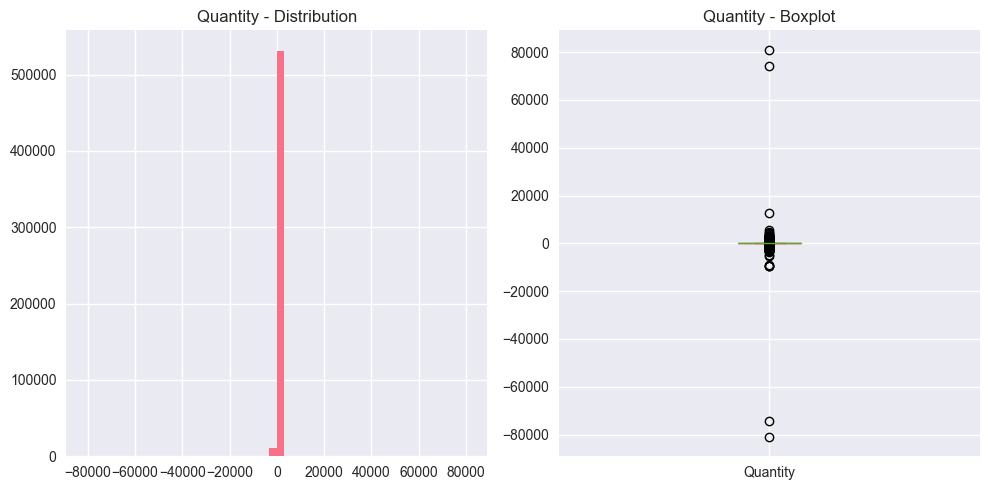


UnitPrice:
   Lower Bound: -3.07
   Upper Bound: 8.45
   Outliers: 39625 (7.31%)
   Min: 0.00, Max: 38970.00


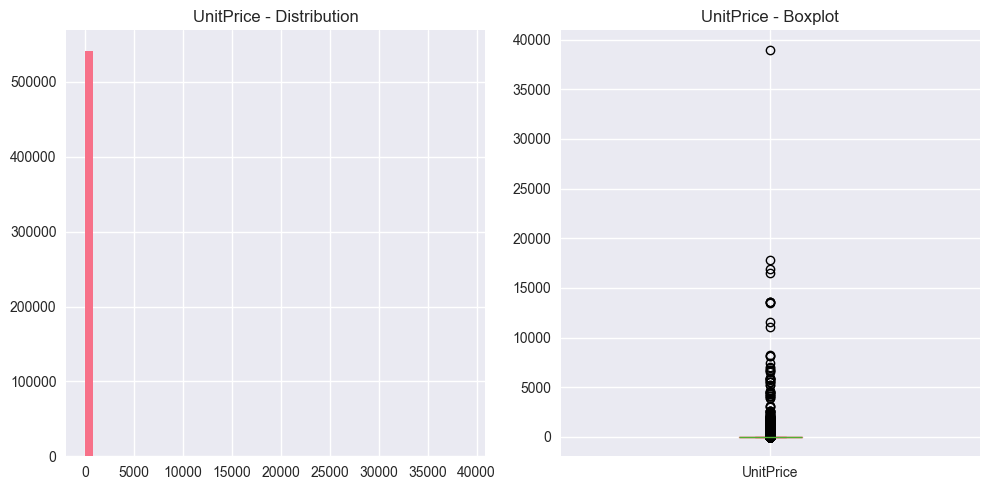


SalesAmount:
   Lower Bound: -17.60
   Upper Bound: 38.40
   Outliers: 44995 (8.30%)
   Min: -168469.60, Max: 168469.60


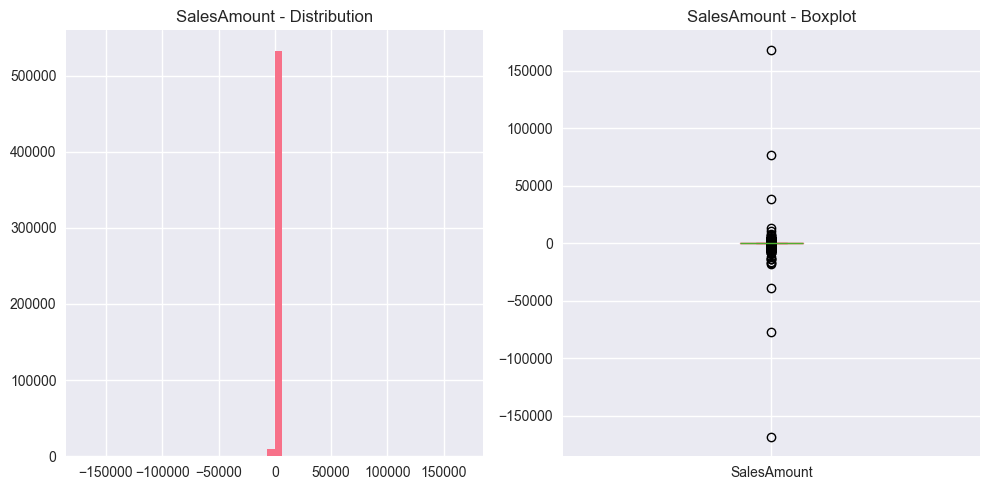

In [17]:
# Detect outliers in numerical columns

def detect_outliers(df):

    print("=== OUTLIER DETECTION ===")

    numerical_cols = ['Quantity', 'UnitPrice', 'SalesAmount']

    outlier_summary = {}

    for col in numerical_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_percentage = (len(outliers) / len(df)) * 100

            print(f"\n{col}:")
            print(f"   Lower Bound: {lower_bound:.2f}")
            print(f"   Upper Bound: {upper_bound:.2f}")
            print(f"   Outliers: {len(outliers)} ({outlier_percentage:.2f}%)")
            print(f"   Min: {df[col].min():.2f}, Max: {df[col].max():.2f}")

            outlier_summary[col] = {
                'count': len(outliers),
                'percentage': outlier_percentage,
                'bounds': (lower_bound, upper_bound)
            }

            # Visualize outliers
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            df[col].hist(bins=50)
            plt.title(f'{col} - Distribution')

            plt.subplot(1,2,2)
            df[col].plot(kind='box')
            plt.title(f'{col} - Boxplot')
            plt.tight_layout()
            plt.show()

    return outlier_summary

outlier_summary = detect_outliers(df_final)

### 18. MULTICOLLINEARITY CHECK

=== MULTICOLLINEARITY CHECK ===
Correlation Matrix:
             Quantity  UnitPrice  SalesAmount
Quantity     1.000000  -0.001283     0.888080
UnitPrice   -0.001283   1.000000    -0.179026
SalesAmount  0.888080  -0.179026     1.000000


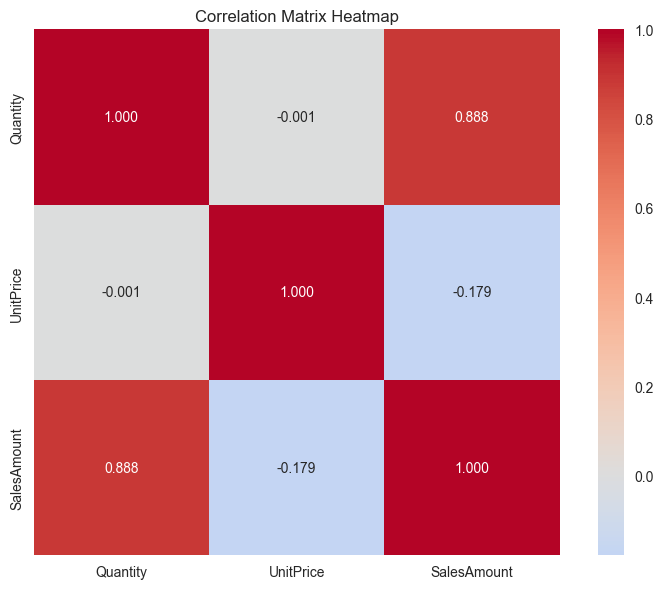


Variance Inflation Factor (VIF):
     Feature       VIF
0      const  1.004353
1   Quantity  1.000002
2  UnitPrice  1.000002

VIF Interpretation:
VIF < 5: Low multicollinearity
5 <= VIF < 10: Moderate multicollinearity
VIF >= 10: High multicollinearity


In [18]:
# Check for multicollinearity in numerical features

def check_multicollinearity(df):

    print("=== MULTICOLLINEARITY CHECK ===")

    # Select numerical columns for correlation analysis
    numerical_cols = ['Quantity', 'UnitPrice', 'SalesAmount']
    numerical_df = df[numerical_cols].copy()

    # Calculate correlation matrix
    correlation_matrix = numerical_df.corr()

    print("Correlation Matrix:")
    print(correlation_matrix)

    # Visualize correlation matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f')
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
    
    # VIF (Variance Inflation Factor) for multicollinearity
    # Note: VIF requires complete cases and meaningful relationships
    numerical_df_clean = numerical_df.dropna()

    if len(numerical_df_clean) > 0:
        # Add constant for VIF calculation
        X = numerical_df_clean[['Quantity', 'UnitPrice']] # Exclude SalesAmount as it's derived
        X = sm.add_constant(X)

        vif_data = pd.DataFrame()
        vif_data['Feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        print("\nVariance Inflation Factor (VIF):")
        print(vif_data)

        # Interpretation
        print("\nVIF Interpretation:")
        print("VIF < 5: Low multicollinearity")
        print("5 <= VIF < 10: Moderate multicollinearity")
        print("VIF >= 10: High multicollinearity")

    return correlation_matrix

correlation_matrix = check_multicollinearity(df_final)

### 19. HETEROSCEDASTICITY CHECK

=== HETEROSCEDASTICITY CHECK ===


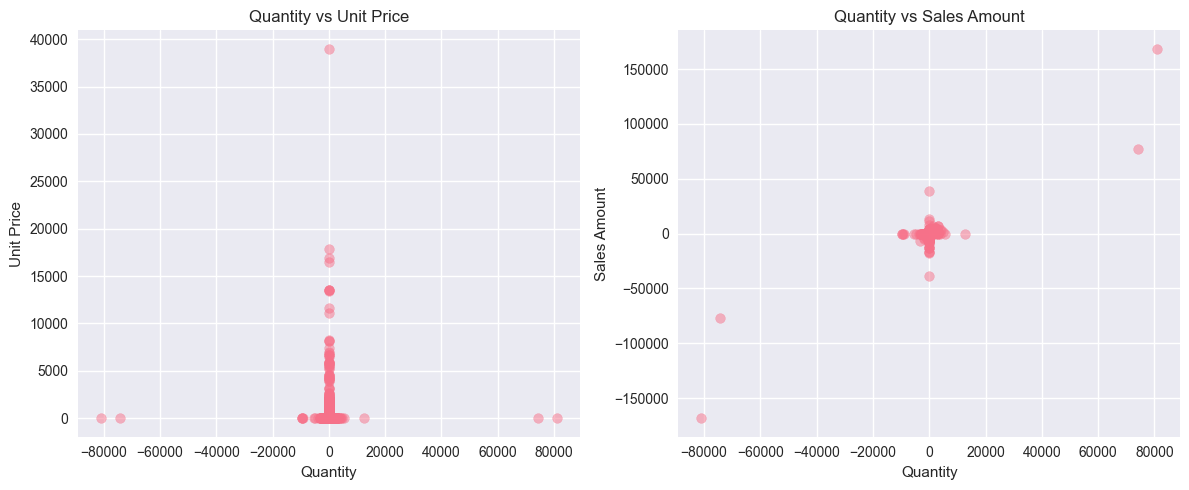

Breusch-Pagan Test for Heteroscedasticity:
LM Statistics: 9.8953
LM p-value: 0.0017
F Statistics: 9.8954
F p-value: 0.0017
 Evidence of heteroscedasticity (p < 0.05)


In [19]:
# Check for heteroscedasticity in relationships

def check_heteroscedasticity(df):

    print("=== HETEROSCEDASTICITY CHECK ===")

    # Create a simple regression plot to check heteroscedasticity
    plt.figure(figsize=(12,5))

    # Plot 1: Quantity vs UnitPrice
    plt.subplot(1,2,1)
    plt.scatter(df['Quantity'], df['UnitPrice'], alpha=0.5)
    plt.xlabel('Quantity')
    plt.ylabel('Unit Price')
    plt.title('Quantity vs Unit Price')

    # plot 2: Quantity vs SalesAmount
    plt.subplot(1,2,2)
    plt.scatter(df['Quantity'], df['SalesAmount'], alpha=0.5)
    plt.xlabel('Quantity')
    plt.ylabel('Sales Amount')
    plt.title('Quantity vs Sales Amount')

    plt.tight_layout()
    plt.show()

    # Statistical test for heteroscedasticity
    # Using Breusch-Pagan test (requires regression)

    try:
        # Prepare data
        X = df[['Quantity']].copy()
        X = sm.add_constant(X)
        y = df['SalesAmount']

        # Remove NaNs values
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull())
        X_clean = X[valid_indices]
        y_clean = y[valid_indices]

        if len(X_clean) > 0:
            # Fit regression model
            model = sm.OLS(y_clean, X_clean).fit()

            # Perform Breusch-Pagan test
            bp_test = sm.stats.het_breuschpagan(model.resid, model.model.exog)

            print("Breusch-Pagan Test for Heteroscedasticity:")
            print(f"LM Statistics: {bp_test[0]:.4f}")
            print(f"LM p-value: {bp_test[1]:.4f}")
            print(f"F Statistics: {bp_test[2]:.4f}")
            print(f"F p-value: {bp_test[3]:.4f}")

            if bp_test[1] < 0.05:
                print(" Evidence of heteroscedasticity (p < 0.05)")
            else:
                print(" No significant evidence of heteroscedasticity")

    except Exception as e:
        print(f"Heteroscedasticity test could not be performed: {e}")

check_heteroscedasticity(df_final)

### 20. COMPREHENSIVE BUSINESS INSIGHTS REPORT

In [24]:
# Generate comprehensive business insights report

def generate_business_insights(df, kpis, outlier_summary, correlation_matrix):

    print("="*80)
    print("COMPREHENSIVE BUSINESS INSIGHT REPORT")
    print("="*80)

    # 1. EXECUTIVE SUMMARY
    print("\n1. EXECUTIVE SUMMARY")
    print(f"   Total Revenue: ${kpis['Total Revenue']:,.2f}")
    print(f"   Average Order Value: ${kpis['Average Order Value (AOV)']:,.2f}")
    print(f"   Customer Base: {kpis['Total Unique Customers']:,} unique customers")
    print(f"   Product Catalog: {kpis['Total Products']:,} unique products")

    # 2. SALES PERFORMANCE INSIGHTS
    print("\n2. SALES PERFORMANCE INSIGHTS")

    # Top performing products
    top_products = df.groupby(['StockCode', 'Description'])['SalesAmount'].sum().nlargest(5)
    print("   Top 5 Products by Revenue:")
    for (code, ptype), sales in top_products.items():
        print(f"    - {ptype} ({code}): ${sales:,.2f}")

    # Geographic performance
    top_countries = df.groupby('Country')['SalesAmount'].sum().nlargest(3)
    print("   Top 3 Countries by Revenue:")
    for country, sales in top_countries.items():
        percentage = (sales / kpis['Total Revenue']) * 100
        print(f"   - {country}: ${sales:,.2f} ({percentage:.1f}%)")

    # 3. CUSTOMER BEHAVIOR INSIGHTS
    print("\n3. CUSTOMER BEHAVIOR INSIGHTS")
    print(f"   Average Purchase Frequency: {kpis['Average Purchase Frequency']:.2f} transactions per customer")
    print(f"   Average Items per Order: {kpis['Average Items per Order']:.2f} items")
    print(f"   Revenue per Customer: ${kpis['Revenue per Customer']:,.2f}")

    # Customer segments
    customer_segments = pd.cut(df.groupby('CustomerID')['SalesAmount'].sum(),
                               bins = [0, 100, 500, 1000, float('inf')],
                               labels = ['Low', 'Medium', 'High', 'VIP'])
    segment_counts = customer_segments.value_counts()
    print("   Customer Segmentation:")
    for segment, count in segment_counts.items():
        print(f"   - {segment} Spenders: {count} customers")

    # 4. DATA QUALITY INSIGHTS
    print("\n4. DATA QUALITY ASSESMENT")
    print(f"   Dataset contains {len(df):,} records")
    print(f"   Data covers period: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")

    # Outlier insights
    for col, summary in outlier_summary.items():
        print(f"   {col}: {summary['count']} outliers ({summary['percentage']:.1f}%)")

    # 5. OPERATIONAL INSIGHTS
    print("\n5. OPERATIONAL INSIGHTS")

    # Time-based patterns
    hourly_sales = df.groupby('Hour')['SalesAmount'].sum()
    peak_hour = hourly_sales.idxmax()
    print(f"   Peak Sales Hour: {peak_hour}:00 (${hourly_sales[peak_hour]:,.2f})")

    weekday_sales = df.groupby('Weekday')['SalesAmount'].sum()
    best_day = weekday_sales.idxmax()
    print(f"   Best Performing Day: {best_day} (${weekday_sales[best_day]:,.2f})")

    # 6. RISK AND OPPORTUNITY ANALYSIS
    print("\n6. RISK AND OPPORTUNITY ANALYSIS")

    # Product concentration risk
    top_10_products_pct = (df.groupby('Description')['SalesAmount'].sum().nlargest(10).sum() / kpis['Total Revenue']) * 100
    print(f"   Top 10 products represent {top_10_products_pct:.1f}% of total revenue")

    # Geographic concentration
    top_country_pct = (top_countries.iloc[0] / kpis['Total Revenue']) * 100
    print(f"   Top country represents {top_country_pct:.1f}% of total revenue")

    # 7. RECOMMENDATIONS
    print("\n7. STRATEGIC RECOMMENDATIONS")

    if top_10_products_pct > 50:
        print("   HIGH PRODUCT CONCENTRATION: Dyversify product portfolio to reduce dependency on top products")
    else:
        print("   HEALTHY PRODUCT DIVERSIFICATION: Continue current product strategy")
    
    if kpis['Average Purchase Frequency'] < 2:
        print("   OPPORTUNITY: Implement customer retention programs to increase purchase frequency")
    else:
        print("   GOOD CUSTOMER RETENTION: Maintain customer engagement strategies")

    if outlier_summary['Quantity']['percentage'] > 5:
        print("   DATA REVIEW: High price outliers detected - review premium products/pricing errors")

generate_business_insights(df_final, kpis, outlier_summary, correlation_matrix)

COMPREHENSIVE BUSINESS INSIGHT REPORT

1. EXECUTIVE SUMMARY
   Total Revenue: $9,769,872.05
   Average Order Value: $18.03
   Customer Base: 4,373 unique customers
   Product Catalog: 4,070 unique products

2. SALES PERFORMANCE INSIGHTS
   Top 5 Products by Revenue:
    - DOTCOM POSTAGE (DOT): $206,245.48
    - REGENCY CAKESTAND 3 TIER (22423): $164,762.19
    - PARTY BUNTING (47566): $98,302.98
    - WHITE HANGING HEART T-LIGHT HOLDER (85123A): $97,715.99
    - JUMBO BAG RED RETROSPOT (85099B): $92,356.03
   Top 3 Countries by Revenue:
   - United Kingdom: $8,209,930.48 (84.0%)
   - Netherlands: $284,661.54 (2.9%)
   - EIRE: $263,276.82 (2.7%)

3. CUSTOMER BEHAVIOR INSIGHTS
   Average Purchase Frequency: 5.92 transactions per customer
   Average Items per Order: 199.86 items
   Revenue per Customer: $2,234.13
   Customer Segmentation:
   - VIP Spenders: 1634 customers
   - Medium Spenders: 1618 customers
   - High Spenders: 906 customers
   - Low Spenders: 165 customers

4. DATA QUALI

### 21. FINAL DATA QUALITY SUMMARY

In [25]:
# Provide final summary of data processing

def final_summary(df_original, df_final):

    print("="*80)
    print("FINAL DATA PROCESSING SUMMARY")
    print("="*80)

    original_rows = len(df_original)
    final_rows = len(df_final)
    data_loss = ((original_rows - final_rows) / original_rows) * 100

    print(f" Original dataset size: {original_rows:,} rows")
    print(f"Final dataset size: {final_rows:,} rows")
    print(f"Data loss: {data_loss:.2f}%")
    print(f"Data retention: {100 - data_loss:.2f}%")

    print("\nData Quality Metrics:")
    print(f"Complete cases: {df_final.isnull().sum().sum()} null values remaining")
    print(f"Duplicate rows: {df_final.duplicated().sum()}")

    # Data types summary
    print("\nFinal Data Types:")
    print(df_final.dtypes)

final_summary(df, df_final)

FINAL DATA PROCESSING SUMMARY
 Original dataset size: 541,909 rows
Final dataset size: 541,907 rows
Data loss: 0.00%
Data retention: 100.00%

Data Quality Metrics:
Complete cases: 0 null values remaining
Duplicate rows: 5268

Final Data Types:
InvoiceNo            category
StockCode            category
Description          category
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country              category
SalesAmount           float64
Year                    int32
Month                   int32
Day                     int32
Weekday                object
Hour                    int32
MonthYear           period[M]
dtype: object
